# Analysis of the dietitian survey responses 

In this notebook, we analyze the survey responses from the evaluation experiment

## Table of Contents

1. [Loading the data and necessary libraries](#loading-the-data-and-necessary-libraries)
2. [Data cleaning](#data-cleaning)

    a. [IS survey cleaning](#is-survey-cleaning)

    b. [FS survey cleaning](#fs-survey-cleaning)

    c. [Update one user email and add institution label](#update-an-email-and-add-institution-labels)

3. [Survey analysis](#survey-analysis)

    a. [IS survey analysis](#is-survey-analysis)

    b. [FS survey analysis](#fs-survey-analysis)

    c. [Both-session survey analysis](#both-session-survey-analysis)

4. [Recommendation analysis](#recommendation-analysis)

    a. [Exclude non-valid recommendations](#exclude-non-valid-recommendations)

    b. [Separate recommendations by patient assignment and sessions](#separate-recommendations)

    c. [Inspection of recommendations to the same patient data](#recommendation-inspection)


## Loading the data and necessary libraries
<a class="anchor" id="loading-the-data-and-necessary-libraries"></a>

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from dotenv import load_dotenv
import utils
import pingouin as pg
import json 

# Load environment variables
plt.rcParams['font.family'] = 'Times New Roman'

# Load data from the user database
recommendation_sessions = pd.read_csv('data/fs_backend_db/recommendation_sessions.csv')
recommendations = pd.read_csv('data/fs_backend_db/recommendations.csv')
users = pd.read_csv('data/fs_backend_db/users.csv')

# Load evaluation survey responses from initial session (IS) and final session (FS)
is_survey = pd.read_excel('data/evaluation_study_results/IS-Evaluation-Survey-Responses.xlsx')
fs_survey = pd.read_excel('data/evaluation_study_results/FS-Evaluation-Survey-Responses.xlsx')


## Data cleaning
<a class="anchor" id="data-cleaning"></a>

### IS survey cleaning
<a class="anchor" id="is-survey-cleaning"></a>

In [2]:
# Drop columns "Email", "Name", "Last modified time"
cleaned_is_survey = is_survey.drop(columns=['Email', 'Name', 'Last modified time'])

# Rename "Student-E-Mail" to "email"
cleaned_is_survey = cleaned_is_survey.rename(columns={'Studien-E-Mail': 'email', 'ID': 'Survey ID'})

# Remove the first response since it was from a test user
cleaned_is_survey = cleaned_is_survey.iloc[1:]

# Add missing period in an email
cleaned_is_survey['email'] = cleaned_is_survey['email'].apply(lambda x: x.replace('@inselch', '@insel.ch'))

# Change email to match the one from the FS
cleaned_is_survey['email'] = cleaned_is_survey['email'].apply(lambda x: x.replace('olzer@gmail.com', 'olzer@kssg.ch'))



### FS survey cleaning
<a class="anchor" id="fs-survey-cleaning"></a>

In [3]:
# Drop columns "Email", "Name", "Last modified time"
cleaned_fs_survey = fs_survey.drop(columns=['Email', 'Name', 'Last modified time'])

# Rename "Student-E-Mail" to "email"
cleaned_fs_survey = cleaned_fs_survey.rename(columns={'Studien-E-Mail': 'email', 'ID': 'Survey ID'})

# Remove the users with email test.1@insel.ch, because two users used the same email
cleaned_fs_survey = cleaned_fs_survey[cleaned_fs_survey['email'] != 'test.1@insel.ch']

# Add missing period in an email
cleaned_fs_survey['email'] = cleaned_fs_survey['email'].apply(lambda x: x.replace('ealeu', 'ea.leu'))


### Update one user email and add institution labels
<a class="anchor" id="update-an-email-and-add-institution-labels"></a>

In [4]:

# Fix email of participant with "di@hotmail.com" to "di@jonco-erb.ch", to align with the user account email
cleaned_is_survey['email'] = cleaned_is_survey['email'].apply(lambda x: x.replace('di@hotmail.com', 'di@jonco-erb.ch'))
cleaned_fs_survey['email'] = cleaned_fs_survey['email'].apply(lambda x: x.replace('di@hotmail.com', 'di@jonco-erb.ch'))

# Add institution labels for IS
is_from_A = (cleaned_is_survey['Start time'] > pd.Timestamp("2024-08-29 12:55:00")) \
    & (cleaned_is_survey['Start time'] < pd.Timestamp("2024-08-29 12:59:59"))

is_from_B = (cleaned_is_survey['Start time'] > pd.Timestamp("2024-10-29 11:30:00")) \
    & (cleaned_is_survey['Start time'] < pd.Timestamp("2024-10-29 11:35:00"))

is_from_C = (cleaned_is_survey['Start time'] > pd.Timestamp("2024-11-11 13:23:00")) \
    & (cleaned_is_survey['Start time'] < pd.Timestamp("2024-11-11 13:32:00"))

is_from_D = (cleaned_is_survey['Start time'] > pd.Timestamp("2024-11-12 13:35:00")) \
    & (cleaned_is_survey['Start time'] < pd.Timestamp("2024-11-12 13:50:59"))

cleaned_is_survey.loc[:,'institution'] = np.select([is_from_A, is_from_B, is_from_C, is_from_D], ["A", "B", "C", "D"], default=None)


# Add institutaion labels for FS
fs_from_A = (cleaned_fs_survey['Start time'] > pd.Timestamp("2024-09-05 12:47:00")) \
    & (cleaned_fs_survey['Start time'] < pd.Timestamp("2024-09-05 12:55:00"))

fs_from_B = (cleaned_fs_survey['Start time'] > pd.Timestamp("2024-10-29 11:45:00")) \
    & (cleaned_fs_survey['Start time'] < pd.Timestamp("2024-10-29 11:49:00"))

fs_from_C = (cleaned_fs_survey['Start time'] > pd.Timestamp("2024-11-11 13:42:00")) \
    & (cleaned_fs_survey['Start time'] < pd.Timestamp("2024-11-11 13:48:00"))

fs_from_D = (cleaned_fs_survey['Start time'] > pd.Timestamp("2024-11-12 13:57:00")) \
    & (cleaned_fs_survey['Start time'] < pd.Timestamp("2024-11-12 14:08:00"))

cleaned_fs_survey.loc[:,'institution'] = np.select([fs_from_A, fs_from_B, fs_from_C, fs_from_D], ["A", "B", "C", "D"], default=None)

## Survey analysis
<a class="anchor" id="survey-analysis"></a>

### IS survey analysis
<a class="anchor" id="is-survey-analysis"></a>

In [5]:
#clean the data
numeric_is_survey = utils.rename_evaluation_survey_columns(cleaned_is_survey, is_initial_session=True)

numeric_is_survey = utils.map_likert_to_numbers(numeric_is_survey, is_initial_session=True)

numeric_is_survey = utils.calculate_aggregated_metrics(numeric_is_survey)



In [6]:
survey_rel_cols = [ 'age', 'gender', 'years_of_experience', 'software_usage', 'sus', 'performance_expectancy', 
                    'effort_expectancy','facilitating_conditions', 'behavioral_intention','hedonic_motivation'] 

numeric_is_survey[survey_rel_cols].describe()

,age,years_of_experience,software_usage,sus,performance_expectancy,effort_expectancy,facilitating_conditions,behavioral_intention,hedonic_motivation
count,32.000000,32.000000,30.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,32.125000,6.234375,3.766667,72.968750,4.416667,5.304688,5.125000,4.854167,5.354167
std,7.399869,6.623497,1.330889,12.303905,1.001791,0.777025,0.741741,0.990773,0.493234
min,22.000000,0.500000,2.000000,47.500000,2.000000,3.250000,4.000000,3.000000,3.666667
25%,26.000000,1.000000,2.000000,61.875000,4.000000,4.937500,4.666667,4.000000,5.000000
50%,29.500000,3.500000,4.000000,73.750000,4.666667,5.250000,5.000000,5.166667,5.333333
75%,35.000000,10.000000,5.000000,82.500000,5.333333,5.750000,5.750000,5.750000,5.666667
max,50.000000,27.000000,5.000000,95.000000,6.000000,7.000000,7.000000,6.000000,6.000000


### FS survey analysis
<a class="anchor" id="fs-survey-analysis"></a>

In [7]:

numeric_fs_survey = utils.rename_evaluation_survey_columns(cleaned_fs_survey, is_initial_session = False)
numeric_fs_survey = utils.map_likert_to_numbers(numeric_fs_survey, is_initial_session = False)
numeric_fs_survey = utils.calculate_aggregated_metrics(numeric_fs_survey)



In [8]:

numeric_fs_survey[survey_rel_cols].describe()

,age,years_of_experience,software_usage,sus,performance_expectancy,effort_expectancy,facilitating_conditions,behavioral_intention,hedonic_motivation
count,32.000000,32.000000,31.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,31.656250,5.937500,3.645161,69.375000,4.062500,5.601562,5.072917,4.385417,5.166667
std,6.645927,6.674156,1.379575,13.167653,1.228215,0.637723,0.717095,1.507709,0.957895
min,22.000000,0.500000,2.000000,42.500000,1.333333,3.750000,3.000000,1.000000,2.000000
25%,26.000000,1.375000,2.000000,59.375000,3.333333,5.250000,4.916667,3.250000,4.916667
50%,30.500000,3.500000,4.000000,70.000000,4.333333,5.750000,5.333333,4.833333,5.333333
75%,34.000000,7.250000,5.000000,77.500000,4.750000,6.000000,5.333333,5.666667,5.750000
max,48.000000,29.000000,5.000000,92.500000,6.000000,7.000000,6.333333,6.000000,6.666667


### Both-session survey analysis
<a class="anchor" id="both-session-survey-analysis"></a>

In [9]:
valid_is_emails = numeric_is_survey["email"]
valid_fs_emails = numeric_fs_survey["email"]

numeric_both_session_is_survey = numeric_is_survey[numeric_is_survey["email"].isin(valid_fs_emails)]
numeric_both_session_fs_survey = numeric_fs_survey[numeric_fs_survey["email"].isin(valid_is_emails)]

In [10]:
additional_cols = ['increase_patient_food_understanding',
                     'improve_nutrition_care_quality',
                     'better_achieve_health_outcomes',
                     'perc_patients_can_benefit',
                     'multi_person_household', 
                     'required_use_of_customer_card',
                     'fpd_only',
                     'migros_coop_only',
                     'medical_diagnosis',
                     'client_demographics',
                     'insurance_coverage',
                     'valuable_compared_to_other_tools',
                     'promote_cost_savings',
                     'price_per_patient_per_month']

numeric_both_session_fs_survey[additional_cols].describe()

,increase_patient_food_understanding,improve_nutrition_care_quality,better_achieve_health_outcomes,perc_patients_can_benefit,multi_person_household,required_use_of_customer_card,fpd_only,migros_coop_only,medical_diagnosis,client_demographics,insurance_coverage,valuable_compared_to_other_tools,promote_cost_savings,price_per_patient_per_month
count,25.000000,25.00,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,0.0
mean,3.920000,3.64,3.480000,2.160000,4.400000,4.080000,4.520000,4.440000,3.640000,3.960000,2.960000,3.000000,2.920000,NaN
std,0.571548,0.70,0.653197,0.943398,0.866025,0.812404,0.509902,0.820569,1.113553,0.789515,0.978093,0.645497,0.759386,NaN
min,3.000000,2.00,2.000000,1.000000,2.000000,2.000000,4.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,NaN
25%,4.000000,3.00,3.000000,2.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,2.000000,3.000000,3.000000,NaN
50%,4.000000,4.00,4.000000,2.000000,5.000000,4.000000,5.000000,5.000000,4.000000,4.000000,3.000000,3.000000,3.000000,NaN
75%,4.000000,4.00,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.000000,NaN
max,5.000000,5.00,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.000000,NaN


In [11]:
numeric_both_session_fs_survey.perc_patients_can_benefit.value_counts()

2    11
3     7
1     6
5     1
Name: perc_patients_can_benefit, dtype: int64

In [12]:
additional_fs_questions = numeric_both_session_fs_survey

#### Get valid recommendations and patient assignments

In [13]:
# Select relevant columns and rename some colums for merging
recommendation_sessions = recommendation_sessions.rename(columns = {'id': 'recommendation_session_id'})
recommendations = recommendations.rename(columns = {'id': 'recommendation_id', 'session_id': 'recommendation_session_id'})

users_rel_cols = users[['id','email']]
users_rel_cols = users_rel_cols.rename(columns = {'id': 'dietician_id'})

# Merge relevant tables from the user database
all_recommendations = recommendations.merge(recommendation_sessions, on = 'recommendation_session_id', how = 'inner')
all_recommendations = all_recommendations.merge(users_rel_cols, on  = 'dietician_id', how = 'inner')

# Merge user data with insitution information
valid_dietitian_email_institution = numeric_both_session_fs_survey[['email', 'institution']]
valid_recommendations = all_recommendations.merge(valid_dietitian_email_institution, on = 'email', how = 'inner')

# Get patient assignments
patient_assignment = valid_recommendations[['user_id', 'email']].drop_duplicates()

#### Merge surveys with assigned patients

In [14]:
numeric_both_session_is_survey = numeric_both_session_is_survey.merge(patient_assignment, on = 'email', how = 'inner')
numeric_both_session_fs_survey = numeric_both_session_fs_survey.merge(patient_assignment, on = 'email', how = 'inner')

#### Both-session survey result overview and visualization

In [15]:
# Get insitution-separated overview
numeric_both_session_is_survey.groupby('institution')[survey_rel_cols].describe().T.to_excel('data/IS_institution_separated_overview.xlsx')
numeric_both_session_fs_survey.groupby('institution')[survey_rel_cols].describe().T.to_excel('data/FS_institution_separated_overview.xlsx')

# Get patient-data-separated overview
numeric_both_session_is_survey.groupby('user_id')[survey_rel_cols].describe().T.to_excel('data/IS_patient_separated_overview.xlsx')
numeric_both_session_fs_survey.groupby('user_id')[survey_rel_cols].describe().T.to_excel('data/FS_patient_separated_overview.xlsx')

#### IS and FS UTAUT2 comparison

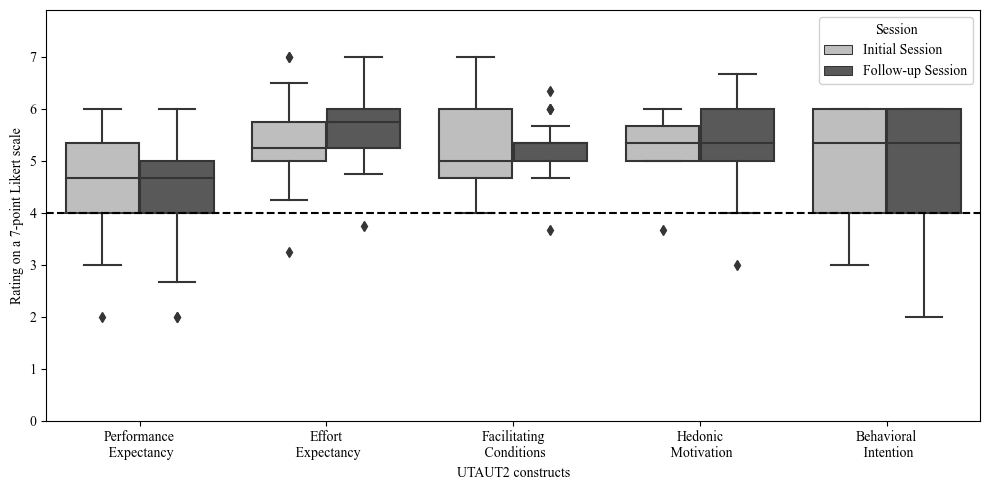

In [16]:

utaut2_cols = ['performance_expectancy',
       'effort_expectancy', 'facilitating_conditions', 
       'hedonic_motivation', 'behavioral_intention']

# Reshape the data from wide to long format
def prepare_data(df_before, df_after):
    # Convert DataFrames to long format
    before_long = df_before.melt(var_name='Group', value_name='Value')
    after_long = df_after.melt(var_name='Group', value_name='Value')
    
    # Add Session column
    before_long['Session'] = 'Initial Session'
    after_long['Session'] = 'Follow-up Session'
    
    # Combine the data
    combined_data = pd.concat([before_long, after_long])
    return combined_data

def create_grouped_boxplots(df_before, df_after):
    # Prepare the data
    data = prepare_data(df_before, df_after)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # Create boxplots using seaborn
    sns.boxplot(data=data, 
                x='Group',
                y='Value',
                hue='Session',
                palette=['#BEBEBE', '#595959'],
                width=0.8, ax = ax)
    
    # Customize the plot
    ax.set_xlabel('UTAUT2 constructs')
    ax.set_ylabel('Rating on a 7-point Likert scale')
    ax.axhline(y=4, color='black', linestyle='--')

    # Adjust legend
    # Customize legend
    ax.legend(
        title='Session',
        loc='upper right',
        frameon=True,
        framealpha=0.9,
        fontsize=10
    )
    ax.set_ylim(0, 7.9)
    # Adjust layout
    # plt.tight_layout()

    x_tick_labels = ["Performance\n Expectancy", "Effort\n Expectancy", "Facilitating\n Conditions", "Hedonic\n Motivation", "Behavioral\n Intention"]
    ax.set_xticks(range(5))
    ax.set_xticklabels(x_tick_labels, fontsize=10)
    plt.tight_layout()
    plt.show()
    return fig


x = create_grouped_boxplots(numeric_both_session_is_survey[utaut2_cols], numeric_both_session_fs_survey[utaut2_cols])

#### IS and FS UTAUT comparison (institution-separated)

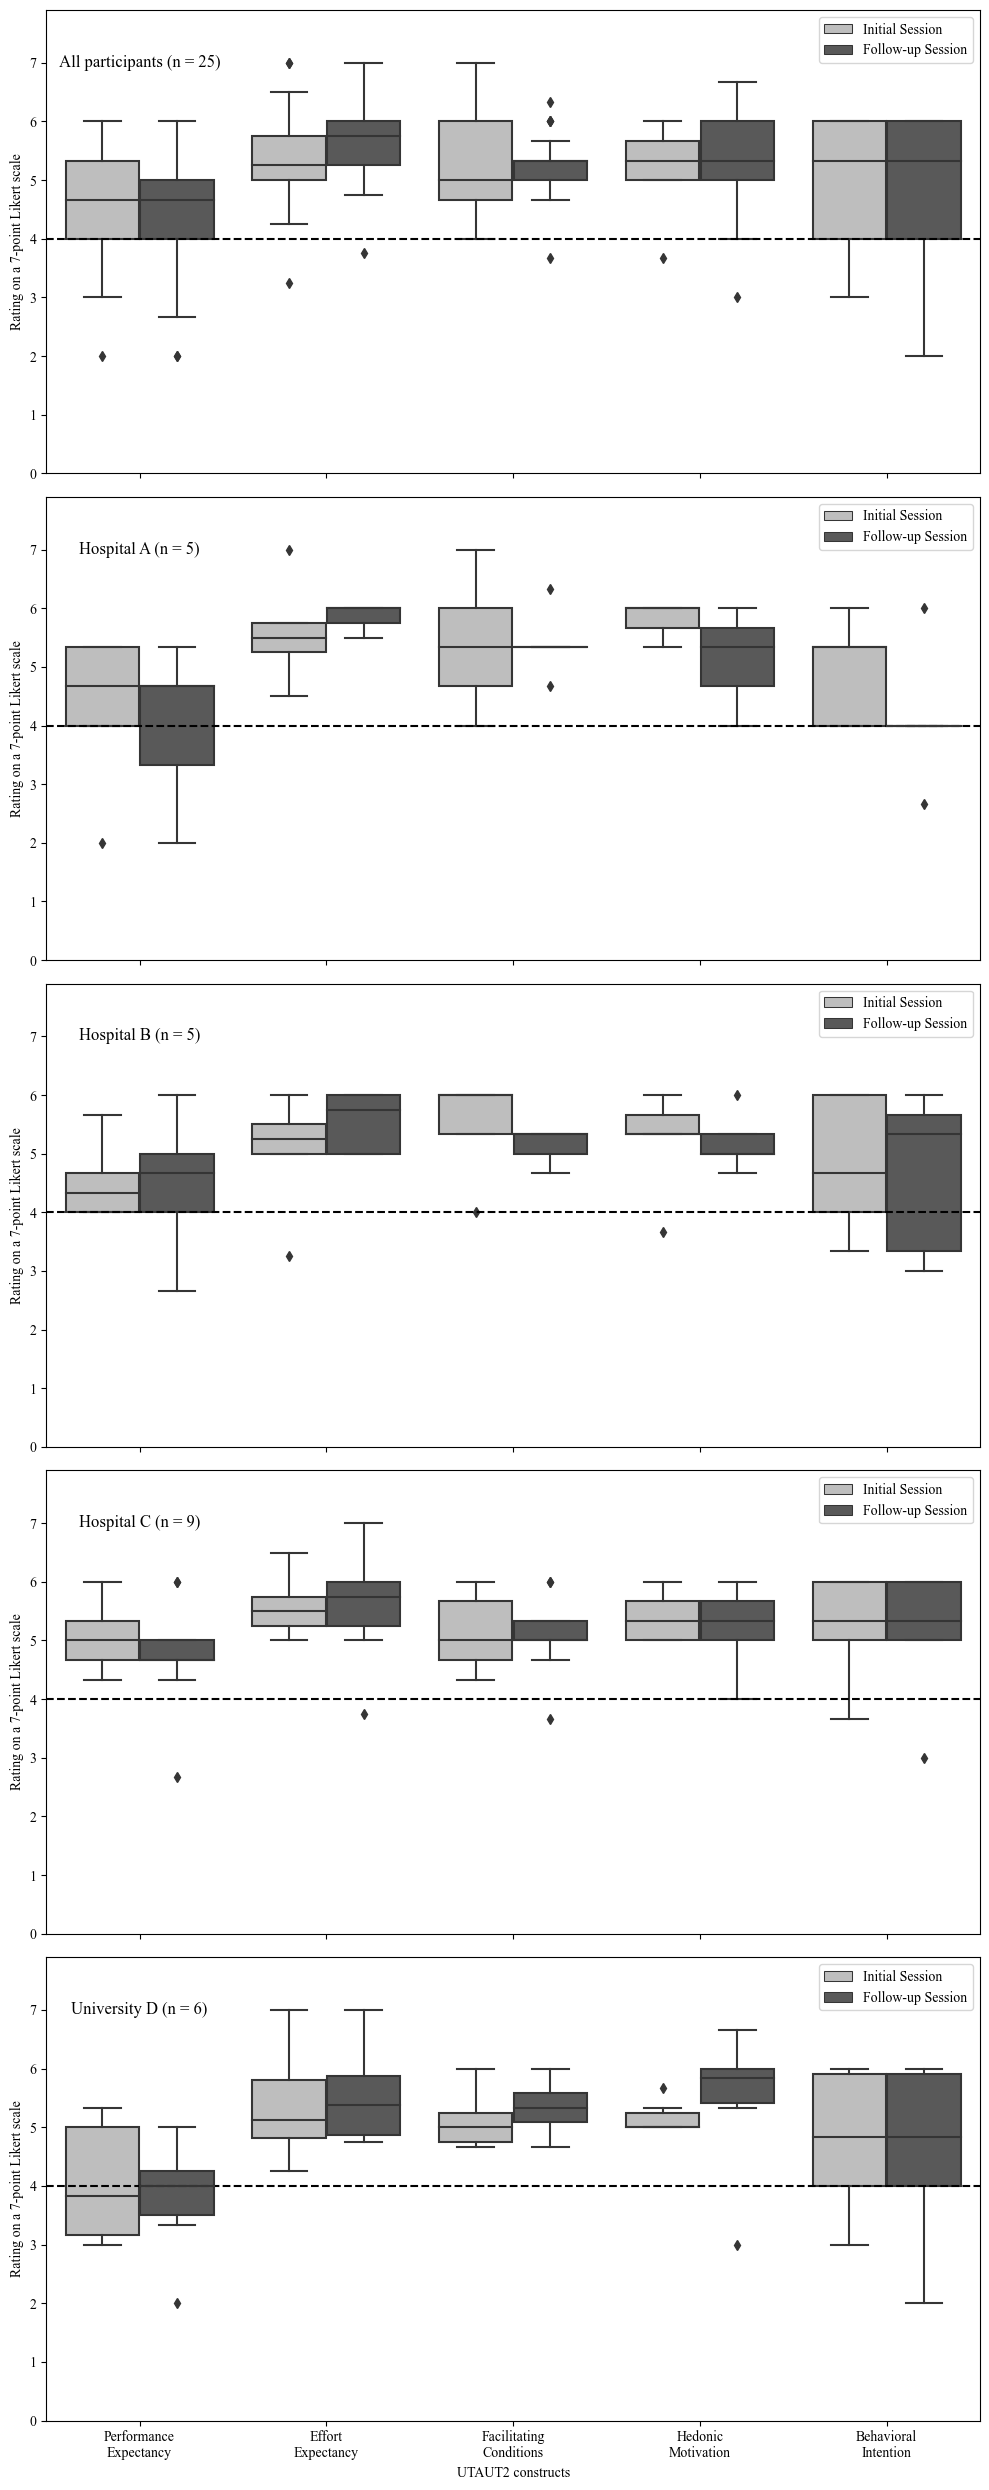

In [17]:
# Define constants
INSTITUTIONS = ['All', "A", "B", "C", "D"]
INSTITUTION_TYPES = {'A': 'Hospital', 'B': 'Hospital', 'C': 'Hospital', 'D': 'University'}

SAMPLE_SIZES = {'All': 25, 'A': 5, 'B': 5, 'C': 9, 'D': 6}
PLOT_CONFIG = {
    'palette': ['#BEBEBE', '#595959'],
    'width': 0.8,
    'x_labels': ["Performance\nExpectancy", "Effort\nExpectancy", 
                 "Facilitating\nConditions", "Hedonic\nMotivation", 
                 "Behavioral\nIntention"]
}

# Get data for institutions
def get_institution_data(institution):
    if institution == 'All':
        return prepare_data(numeric_both_session_is_survey[utaut2_cols], 
                          numeric_both_session_fs_survey[utaut2_cols])
    else:
        is_mask = numeric_both_session_is_survey.institution == institution
        fs_mask = numeric_both_session_fs_survey.institution == institution
        return prepare_data(numeric_both_session_is_survey[is_mask][utaut2_cols],
                          numeric_both_session_fs_survey[fs_mask][utaut2_cols])

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 25), sharex=True, sharey=True)

# Plot each institution
for i, inst in enumerate(INSTITUTIONS):
    # Create boxplot
    sns.boxplot(data=get_institution_data(inst), x='Group', y='Value', 
                hue='Session', palette=PLOT_CONFIG['palette'], 
                width=PLOT_CONFIG['width'], ax=axes[i])
    
    # Add reference line and legend
    axes[i].axhline(y=4, color='black', linestyle='--')
    axes[i].legend(loc='upper right')
    
    # Add title text
    # Add title text
    if inst == 'All':
        title = f'All participants (n = {SAMPLE_SIZES[inst]})'
    else:
        institution_type = INSTITUTION_TYPES[inst]
        title = f'{institution_type} {inst} (n = {SAMPLE_SIZES[inst]})'
    axes[i].text(0, 7, title, ha='center', va='center', fontsize=12)
    
    # Set labels for bottom plot only
    axes[i].set_xlabel('UTAUT2 constructs' if i == 4 else '')  # Only show x-label on bottom plot
    axes[i].set_ylabel('Rating on a 7-point Likert scale')
    axes[i].set_xticklabels(PLOT_CONFIG['x_labels'])

plt.ylim(0, 7.9)
plt.tight_layout()

#### Comparisons between different assigned patients

##### SUS comparison

In [18]:
numeric_both_session_is_survey.groupby('user_id')['sus'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
1,6.0,72.916667,14.698356,60.0,60.625,68.75,82.50,95.0
2,7.0,73.928571,14.351041,55.0,63.750,72.50,86.25,90.0
3,12.0,72.083333,11.522376,47.5,65.000,75.00,77.50,92.5


In [19]:
numeric_both_session_fs_survey.groupby('user_id')['sus'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
1,6.0,73.333333,15.545632,57.5,60.625,70.00,86.875,92.5
2,7.0,67.500000,16.583124,42.5,58.750,70.00,75.000,92.5
3,12.0,71.458333,11.987604,45.0,68.750,73.75,75.625,92.5


##### UTAUT2 comparison

In [20]:
# prepare data
utaut2_is_data_long = numeric_both_session_is_survey.melt(
            id_vars=['user_id'],
            value_vars=utaut2_cols,
            var_name='Measurement',
            value_name='Value'
        )
utaut2_fs_data_long = numeric_both_session_fs_survey.melt(
            id_vars=['user_id'],
            value_vars=utaut2_cols,
            var_name='Measurement',
            value_name='Value'
        )

def rename_user_ids(df):
    df['user_id'] = df['user_id'].replace({1: 'H', 2: 'M', 3: 'L'})
    return df
utaut2_is_data_long = rename_user_ids(utaut2_is_data_long)
utaut2_fs_data_long = rename_user_ids(utaut2_fs_data_long)

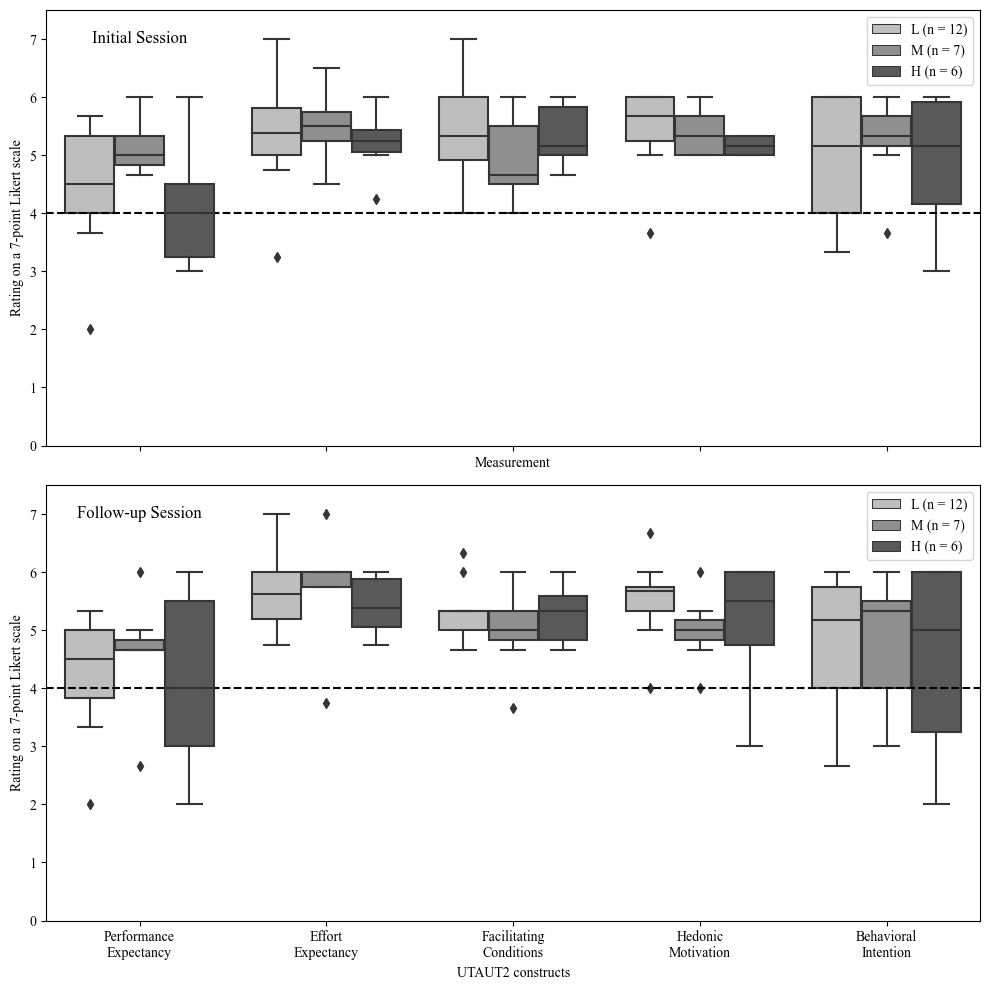

In [21]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)

# Plot boxplots
sns.boxplot(data=utaut2_is_data_long, x='Measurement', y='Value', 
            hue='user_id', palette=['#BEBEBE', '#8F8F8F', '#595959'], 
            width=0.8, ax=ax1)
sns.boxplot(data=utaut2_fs_data_long, x='Measurement', y='Value', 
            hue='user_id', palette=['#BEBEBE','#8F8F8F', '#595959'], 
            width=0.8, ax=ax2)

# Add custom legend labels with counts
for ax, df_long, df_orig, title in zip(
    [ax1, ax2],
    [utaut2_is_data_long, utaut2_fs_data_long],
    [numeric_both_session_is_survey, numeric_both_session_fs_survey],
    ['Initial Session', 'Follow-up Session']
):
    # Add reference line and basic formatting
    ax.axhline(y=4, color='black', linestyle='--')
    ax.set_ylabel('Rating on a 7-point Likert scale')
    
    # Get counts for each level (1=H, 2=M, 3=L)
    level_counts = df_orig['user_id'].value_counts().sort_index()
    level_counts.index = ['H', 'M', 'L']
    
    handles, labels = ax.get_legend_handles_labels()
    
    # Update legend with participant count for each level
    new_labels = [f'{label} (n = {level_counts[label]})' for label in labels]
    ax.legend(handles, new_labels, loc='upper right')
    
    # Add title
    ax.text(0, 7, title, ha='center', va='center', fontsize=12)

# Set x labels
ax2.set_xlabel('UTAUT2 constructs')
plt.xticks(range(5), ["Performance\nExpectancy", "Effort\nExpectancy", 
                      "Facilitating\nConditions", "Hedonic\nMotivation", 
                      "Behavioral\nIntention"])
plt.ylim(0, 7.5)
plt.tight_layout()

##### UTAUT2 contruction correlation analysis
<a class="anchor" id="survey-analysis"></a>

In [22]:
# UTAUT2 construct Correlation Analysis
is_correlation_matrix = pg.pairwise_corr(numeric_both_session_is_survey[survey_rel_cols])
is_correlation_matrix

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,age,years_of_experience,pearson,two-sided,25,0.753011,"[0.51, 0.88]",0.000014,1805.099,0.996579
1,age,software_usage,pearson,two-sided,24,-0.007212,"[-0.41, 0.4]",0.973319,0.253,0.049500
2,age,sus,pearson,two-sided,25,-0.234619,"[-0.58, 0.18]",0.258946,0.454,0.206786
3,age,performance_expectancy,pearson,two-sided,25,0.029704,"[-0.37, 0.42]",0.887913,0.251,0.051697
4,age,effort_expectancy,pearson,two-sided,25,-0.453911,"[-0.72, -0.07]",0.022657,2.898,0.646426
5,age,facilitating_conditions,pearson,two-sided,25,0.236293,"[-0.18, 0.58]",0.255465,0.458,0.209182
6,age,behavioral_intention,pearson,two-sided,25,-0.127928,"[-0.5, 0.28]",0.542255,0.296,0.093539
7,age,hedonic_motivation,pearson,two-sided,25,-0.051294,"[-0.44, 0.35]",0.807617,0.255,0.056292
8,years_of_experience,software_usage,pearson,two-sided,24,-0.148804,"[-0.52, 0.27]",0.487714,0.318,0.107019
9,years_of_experience,sus,pearson,two-sided,25,-0.221898,"[-0.57, 0.19]",0.286402,0.425,0.189213


In [23]:
# UTAUT2 construct Correlation Analysis
fs_correlation_matrix = pg.pairwise_corr(numeric_both_session_fs_survey[survey_rel_cols])
fs_correlation_matrix

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,age,years_of_experience,pearson,two-sided,25,0.521397,"[0.16, 0.76]",7.520813e-03,7.276,0.787573
1,age,software_usage,pearson,two-sided,24,0.019417,"[-0.39, 0.42]",9.282437e-01,0.254,0.050310
2,age,sus,pearson,two-sided,25,-0.008009,"[-0.4, 0.39]",9.696905e-01,0.248,0.049560
3,age,performance_expectancy,pearson,two-sided,25,0.110988,"[-0.3, 0.48]",5.973850e-01,0.283,0.082360
4,age,effort_expectancy,pearson,two-sided,25,-0.093869,"[-0.47, 0.31]",6.553782e-01,0.273,0.072806
5,age,facilitating_conditions,pearson,two-sided,25,-0.143039,"[-0.51, 0.27]",4.951766e-01,0.309,0.105006
6,age,behavioral_intention,pearson,two-sided,25,-0.092329,"[-0.47, 0.31]",6.606975e-01,0.272,0.072031
7,age,hedonic_motivation,pearson,two-sided,25,0.103221,"[-0.3, 0.48]",6.234278e-01,0.278,0.077812
8,years_of_experience,software_usage,pearson,two-sided,24,-0.310264,"[-0.63, 0.11]",1.400695e-01,0.709,0.321512
9,years_of_experience,sus,pearson,two-sided,25,-0.352714,"[-0.66, 0.05]",8.374451e-02,1.023,0.420011


## Recommendation analysis
<a class="anchor" id="recommendation-analysis"></a>

#### Exclude non-valid recommendations
<a class="anchor" id="exclude-non-valid-recommendations"></a>

In [24]:
def extract_basket_numbers(json_string):
    # Load the JSON string into a list
    urls = json.loads(json_string)  
    # Extract numbers after 'Basket-' from each URL
    numbers = [url.split('Basket-')[1] for url in urls]
    
    return str(numbers)

def add_is_fs_column(recommendations):
    """
    Add 'is_fs' column to recommendations DataFrame indicating first (s1) or second (s2) 
    session for participants who have exactly two session ids. Entries that don't meet 
    the criteria will have NaN in the 'is_fs' column.
    
    Parameters:
    recommendations (pd.DataFrame): Input DataFrame containing recommendations
    
    Returns:
    pd.DataFrame: Original recommendations with additional 'is_fs' column
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    recommendations_copy = recommendations.copy()
    
    # Initialize 'is_fs' column with NaN
    recommendations_copy['is_fs'] = pd.NA
    
    # Sort by dietician_id and recommendation_session_id
    recommendations_sorted = recommendations_copy.sort_values(['dietician_id', 'recommendation_session_id'])
    
    # Group by dietician_id and get unique session IDs for each dietician
    dietician_sessions = recommendations_sorted.groupby('dietician_id')['recommendation_session_id'].unique()
    
    # Filter for dieticians with exactly 2 sessions
    two_session_dieticians = dietician_sessions[dietician_sessions.apply(len) == 2]
    
    if not two_session_dieticians.empty:
        # Get first and last session IDs for qualifying dieticians
        s1 = two_session_dieticians.apply(lambda x: x[0])
        s2 = two_session_dieticians.apply(lambda x: x[1])
        
        # Create masks for first and last sessions
        s1_mask = (
            recommendations_sorted['dietician_id'].isin(two_session_dieticians.index) & 
            recommendations_sorted['recommendation_session_id'].isin(s1)
        )
        s2_mask = (
            recommendations_sorted['dietician_id'].isin(two_session_dieticians.index) & 
            recommendations_sorted['recommendation_session_id'].isin(s2)
        )
        
        # Update 'is_fs' column based on masks
        recommendations_sorted.loc[s1_mask, 'is_fs'] = 's1'
        recommendations_sorted.loc[s2_mask, 'is_fs'] = 's2'
    
    return recommendations_sorted


In [25]:
# Create a copy first
valid_recommendations = valid_recommendations.copy()

# Count numbers of baskets, bad products, and product suggestions
valid_recommendations.loc[:,'num_of_baskets'] = valid_recommendations.loc[:, 'basket_ids'].apply(lambda x: len(json.loads(x)))
valid_recommendations.loc[:,'num_of_bad_products'] = valid_recommendations.loc[:, 'bad_products'].apply(lambda x: len(json.loads(x)))
valid_recommendations.loc[:,'num_of_product_suggestions'] = valid_recommendations.loc[:, 'suggestions'].apply(lambda x: len(json.loads(x)))

# Extract bakset numbers
valid_recommendations.basket_ids = valid_recommendations.basket_ids.apply(extract_basket_numbers)

In [26]:
print(f"There were {valid_recommendations.shape[0]} recommendations from {len(valid_recommendations.dietician_id.unique())} dietitians")

There were 59 recommendations from 25 dietitians


In [27]:
# Drop a recommendation, because the user were considering all baskets in session 2. It is hard to compare similarities.
valid_recommendations = valid_recommendations[valid_recommendations.recommendation_id != 172]
print(f"There were {valid_recommendations.shape[0]} recommendations from {len(valid_recommendations.dietician_id.unique())} dietitians")

There were 58 recommendations from 25 dietitians


#### Separate recommendations by patient assignment and sessions
<a class="anchor" id="separate-recommendations"></a>

In [28]:
# Add is_fs columns
valid_recommendations = add_is_fs_column(valid_recommendations)

# Manually inspect the basket ids to assign sessions
valid_recommendations.loc[valid_recommendations.recommendation_id.isin([36,38,64,166]),'is_fs'] = 's1'
valid_recommendations.loc[valid_recommendations.recommendation_id.isin([72,74, 66, 171]),'is_fs'] = 's2'

In [29]:
valid_recommendations = valid_recommendations[['recommendation_id', 'recommendation_session_id',
       'recommendation_index', 'variant', 'mode', 'nutrient', 'category',
       'text',  'notes',
       'dietician_id', 'user_id', 'session_index', 'patient_note',
       'personal_note', 'institution', 'num_of_baskets',
       'num_of_bad_products', 'num_of_product_suggestions', 'is_fs']]

#Differentiate data from 6 groups
p1_s1_recommendations = valid_recommendations[(valid_recommendations.user_id == 1) & (valid_recommendations.is_fs == 's1')]
p1_s2_recommendations = valid_recommendations[(valid_recommendations.user_id == 1) & (valid_recommendations.is_fs == 's2')]
p2_s1_recommendations = valid_recommendations[(valid_recommendations.user_id == 2) & (valid_recommendations.is_fs == 's1')]
p2_s2_recommendations = valid_recommendations[(valid_recommendations.user_id == 2) & (valid_recommendations.is_fs == 's2')]
p3_s1_recommendations = valid_recommendations[(valid_recommendations.user_id == 3) & (valid_recommendations.is_fs == 's1')]
p3_s2_recommendations = valid_recommendations[(valid_recommendations.user_id == 3) & (valid_recommendations.is_fs == 's2')]

In [30]:
valid_recommendations.to_excel('Valid recommendations.xlsx', index = False)

#### Insepction of recommendations to the same patient data
<a class="anchor" id="recommendation-inspection"></a>

In [31]:

def print_descrptive_info(df):
    print(f"""
    The number of dietitians is {len(df.dietician_id.unique())}.
    The number of recommendations given is {df.shape[0]}.
    The number of baksets looked at is {df.num_of_baskets.mean(), df.num_of_baskets.std()}.
    The number of bad products is {df.num_of_bad_products.mean(), df.num_of_bad_products.std()}.
    The number of product alternative is {df.num_of_product_suggestions.mean(), df.num_of_product_suggestions.std()}.
    Different recommendation variants: 
    {df.variant.value_counts()}
    Categories: 
    {df.category.value_counts()}
    Nutrients:
    {df.nutrient.value_counts()}
    Directions of change
    {df['mode'].value_counts()}
    No product reecommendation:
    {df[(df.num_of_bad_products == 0) & (df.num_of_product_suggestions == 0)].shape[0]}
    With additional explanation
    {df[~df.notes.isna()].shape[0]}""")


In [32]:
print_descrptive_info(p3_s2_recommendations)


    The number of dietitians is 10.
    The number of recommendations given is 12.
    The number of baksets looked at is (7.833333333333333, 0.38924947208076155).
    The number of bad products is (2.0833333333333335, 2.3143164446679725).
    The number of product alternative is (1.6666666666666667, 1.1547005383792515).
    Different recommendation variants: 
    VAR1        10
FREITEXT     1
VAR2         1
Name: variant, dtype: int64
    Categories: 
    Snacks                          7
Gemüse                          2
Milchprodukte & Alternativen    1
Fett, Öle & Nüsse               1
Name: category, dtype: int64
    Nutrients:
    Kohlenhydrate     4
Fette             3
Menge             2
Nahrungsfasern    1
Name: nutrient, dtype: int64
    Directions of change
    Reduzieren              5
Erhöhen / Reduzieren    4
Erhöhen                 2
Name: mode, dtype: int64
    No product reecommendation:
    1
    With additional explanation
    3
